In [1]:
import numpy as np
from numpy import linalg as LA
import torch; torch.set_default_dtype(torch.float64)
import torch.nn as nn
import torch.optim as optim
import copy
from copy import deepcopy
import matplotlib.pyplot as plt
# import mymodule as myModules
import matplotlib.cm as cm
from scipy import linalg
from timeit import default_timer as timer
import networkx as nx
import os
import pickle
import datetime
#### Import SLOG packakes
from SLOGmodules import SLOGtools as SLOGtools
from SLOGmodules import SLOGobjective as SLOGobj
from SLOGmodules import SLOGarchitectures as SLOGarchi 
from SLOGmodules import SLOGtraining as SLOGtrainer
from SLOGmodules import SLOGmodel as SLOGmodel
from SLOGmodules import SLOGevaluation as SLOGevaluator
from SLOGmodules import SLOGdata as SLOGdata

#### Import GNN packages
from SLOGmodules import graphTools as graphTools
from SLOGmodules import dataTools as dataTools

from alegnn.modules import architectures as archit
from alegnn.modules import model as model
from alegnn.modules import training as training
from alegnn.modules import evaluation as evaluation
from alegnn.modules import loss as loss
from alegnn.utils.miscTools import writeVarValues
from alegnn.utils.miscTools import saveSeed

In [2]:
# from numpy import random
# xy = random.rand(3)
# print(xy)
# print(1 != 2)
# print(xy**2)
# import hdf5storage

In [3]:
### Network parameters
K = 5 # number of layers

### Filter parameters
alpha = 1.0

Parameters

In [4]:
### Simulation parameters
simuParas = {}
nTrain_slog = 10000
batchsize_slog = 400
nValid = batchsize_slog
nTest = batchsize_slog

### Data parameters
L = 5
alpha = 1.0

### Graph parameters

nNodes = 20 # Number of nodes
nClasses = 3 # Number of classes (i.e. number of communities)
N_C = 2 # Number of sources per signal

# nNodes = 100 # Number of nodes
# nClasses = 5 # Number of classes (i.e. number of communities)
# N_C = 10 # Number of sources per signal

simuParas['nNodes'] = nNodes
simuParas['nClasses'] = nClasses
simuParas['N_C'] = N_C

# graphType = 'SBM' # Type of graph
# graphOptions = {} # Dictionary of options to pass to the graphTools.createGraph function
# graphOptions['nCommunities'] = nClasses # Number of communities
# graphOptions['probIntra'] = 0.8 # Probability of drawing edges intra communities
# graphOptions['probInter'] = 0.2 # Probability of drawing edges inter communities

# graphType = 'Random Geometric' # Type of graph
# graphOptions = {} # Dictionary of options to pass to the graphTools.createGraph function
# graphOptions['distance'] = 0.2 # Number of communities

# graphType = 'BA' # Type of graph
# graphOptions = {} # Dictionary of options to pass to the graphTools.createGraph function
# graphOptions['alpha'] = 1.0

graphType = 'ER' # Type of graph
graphOptions = {} # Dictionary of options to pass to the graphTools.createGraph function
graphOptions['probIntra'] = 0.3 # Probability of drawing edges

### Training parameters
nEpochs = 50

## Filter type: g or h
# filterType = 'g'
filterType = 'h'

## Signal mode: gaussion or 1
signalMode = 'Gaussion'

## Train mode: Wt or default (Vdiag(\tilde{h})V^T)
trainMode = 'default'
# trainMode = 'Wt'

## Filter mode: Wt or default (Vdiag(\tilde{h})V^T)
filterMode = 'default'
# filterMode = 'Wt'

## Selection mode: random or nodes with top-N_C degree
selectMode = 'random'

## Noise level
noiseLevel = 0.1

simuParas['nTrain_slog'] = nTrain_slog
simuParas['batchsize_slog'] = batchsize_slog
simuParas['nValid'] = nValid
simuParas['nTest'] = nTest
simuParas['L'] = L
simuParas['noiseLevel'] = noiseLevel
simuParas['filterType'] = filterType
simuParas['signalMode'] = signalMode
simuParas['trainMode'] = trainMode
simuParas['filterMode'] = filterMode
simuParas['selectMode'] = selectMode
simuParas['graphType'] = graphType 
simuParas['nEpochs'] = nEpochs

tMax = None # Maximum number of diffusion times (W^t for t < tMax)
tMax = 3


Save Settings

In [5]:
thisFilename_SLOG = 'sourceLocSLOGNET' # This is the general name of all related files
saveDirRoot = 'experiments' # Relative location where to save the file
saveDir = os.path.join(saveDirRoot, thisFilename_SLOG) # Dir where to save all the results from each run

saveDirRoot_dropbox = '/Users/changye'
saveDirRoot_dropbox = os.path.join(saveDirRoot_dropbox, 'Dropbox')
saveDirRoot_dropbox = os.path.join(saveDirRoot_dropbox, 'onlineResults')
saveDir_dropbox = os.path.join(saveDirRoot_dropbox, saveDir)


#\\\ Create .txt to store the values of the setting parameters for easier
# reference  when running multiple experiments
today = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
# Append date and time of the run to the directory, to avoid several runs of
# overwritting each other.
saveDir = saveDir + '-' + graphType + '-' + today
saveDir_dropbox = saveDir_dropbox + '-' + graphType + '-' + today
# 
saveDirs = {}
saveDirs['saveDir'] = saveDir
saveDirs['saveDir_dropbox'] = saveDir_dropbox

# Create directory
if not os.path.exists(saveDir):
    os.makedirs(saveDir)

if not os.path.exists(saveDir_dropbox):
    print("Create: ",saveDir_dropbox)
    os.makedirs(saveDir_dropbox)    

useGPU = True
if useGPU and torch.cuda.is_available():
    device = 'cuda:0'
    torch.cuda.empty_cache()
else:
    device = 'cpu'
# Notify:
print("Device selected: %s" % device)   

# Create the file where all the (hyper)parameters are results will be saved.
varsFile = os.path.join(saveDir,'hyperparameters.txt')
with open(varsFile, 'w+') as file:
    file.write('%s\n\n' % datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

#\\\ Save values:
writeVarValues(varsFile, {'nNodes': nNodes, 'graphType': graphType})
writeVarValues(varsFile, graphOptions)
writeVarValues(varsFile, simuParas)
writeVarValues(varsFile, saveDirs)
writeVarValues(varsFile, {'nTrain': nTest,
                          'nValid': nValid,
                          'nTest': nTest,
                          'tMax': tMax,
                          'nClasses': nClasses,
                          'useGPU': useGPU})


# Create the file where all the (hyper)parameters are results will be saved.
varsFile = os.path.join(saveDir_dropbox,'hyperparameters.txt')
with open(varsFile, 'w+') as file:
    file.write('%s\n\n' % datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

#\\\ Save values:
writeVarValues(varsFile, {'nNodes': nNodes, 'graphType': graphType})
writeVarValues(varsFile, graphOptions)
writeVarValues(varsFile, simuParas)
writeVarValues(varsFile, saveDirs)
writeVarValues(varsFile, {'nTrain': nTest,
                          'nValid': nValid,
                          'nTest': nTest,
                          'tMax': tMax,
                          'nClasses': nClasses,
                          'useGPU': useGPU})

optimAlg = 'ADAM'
# learningRate = 0.001
learningRate = 0.01
beta1 = 0.9
beta2 = 0.999

Create:  /Users/changye/Dropbox/onlineResults/experiments/sourceLocSLOGNET-ER-20220701192949
Device selected: cpu


In [6]:
print(saveDir)

experiments/sourceLocSLOGNET-ER-20220701192949


Graph Generation

C =  3 , Community nodes: [ 1  2  4  5  7 10 15 17 19]
Degress of community nodes: [6 5 7 7 6 7 8 5 6]
Sorted degress: [1 7 0 4 8 2 3 5 6]
Randomized sorted degress: [1 2 3 7 5 8 0 6 4]
C =  3 , Community nodes: [ 0  9 11 12 13 16]
Degress of community nodes: [ 6  6 10  7  6  5]
Sorted degress: [5 0 1 4 3 2]
Randomized sorted degress: [1 0 5 2 4 3]
C =  3 , Community nodes: [ 3  6  8 14 18]
Degress of community nodes: [6 5 7 4 7]
Sorted degress: [3 1 0 2 4]
Randomized sorted degress: [1 0 3 4 2]
Source nodes: [array([15,  7]), array([13, 12]), array([18,  8])]
Community Labels: [1 0 0 2 0 0 2 0 2 1 0 1 1 1 2 0 1 0 2 0]
Community List: [array([ 1,  2,  4,  5,  7, 10, 15, 17, 19]), array([ 0,  9, 11, 12, 13, 16]), array([ 3,  6,  8, 14, 18])]


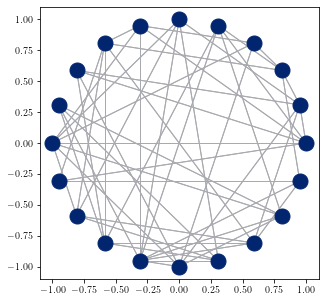

In [7]:
# G = graphTools.Graph(graphType, nNodes, graphOptions)
G = SLOGtools.Graph(graphType, nNodes, graphOptions, save_dir = saveDir, save_dir_dropBox = saveDir_dropbox)
G.computeGFT()
graphTools.plotGraph(G.A)
sourceNodes, communityLabels,communityList = SLOGtools.computeSourceNodes_slog(G.A, nClasses, N_C, mode = 'random')
d_slog,An_slog, eigenvalues_slog, V_slog   = SLOGtools.get_eig_normalized_adj(G.A)

# print(G.A)




In [8]:
from numpy.linalg import matrix_rank
print( matrix_rank(G.A),G.N)
# print(An_slog)
print(eigenvalues_slog)


20 20
[ 1.          0.63084083  0.60368559 -0.37190798 -0.35085182 -0.29410798
  0.50981512  0.47746039 -0.2284341  -0.17110606 -0.13018803  0.39081621
  0.36442526 -0.02109401 -0.01226711  0.06569262  0.10651229  0.28743785
  0.24183953  0.20024091]


Data Generation

In [9]:

print(nTrain_slog + nValid + nTest)

data = SLOGdata.SLOG_ClassificationData(G, nTrain_slog, nValid, nTest, sourceNodes, communityList, communityLabels, V_slog, eigenvalues_slog, L = L, tMax = tMax, alpha = alpha, filterMode = filterMode, selectMode = selectMode, signalMode = signalMode, filterType = filterType, noiseLevel = noiseLevel)
# data = SLOGdata.SLOGdata(G, nTrain_slog, nValid, nTest, sourceNodes, communityList,communityLabels, V_slog,eigenvalues_slog,alpha = 1.0, selectMode = 'random',signalMode = 'Gaussion')

data.astype(torch.float64)
data.expandDims()

10800
<class 'numpy.float64'>
Number of input nodes per classes: 2 ; number of classes 3
Generating h filter
[0.87195572 0.68866377 0.68954665 2.03130643 1.84991401 1.5179566
 0.6998431  0.70569862 1.28749348 1.15502064 1.08374429 0.72655545
 0.73434679 0.94968372 0.94128423 0.87763127 0.85029591 0.76093093
 0.77953966 0.79858871]


/Users/changye/github/slog-net/slog-net-master/graph-neural-networks-master/SLOGmodules/SLOGdata.py:669: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  communityNode_set = np.array(communityList)


Signal shape: torch.Size([10800, 20])
key: train
key: valid
key: test
key: train
key: valid
key: test


/Users/changye/github/slog-net/slog-net-master/graph-neural-networks-master/SLOGmodules/SLOGdata.py:744: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(x_slog + noiseLevel*noise)# nTotal x N


In [10]:
# print(myModel.archit.state_dict())

SLOG-Net Model

In [11]:
C = 1
K = 5
filterTrainType = 'g'
# filterTrainType = 'h'
# tMax = 5
thisLoss = SLOGtools.myLoss
thisEvaluator = SLOGevaluator.evaluate

# thisObject = SLOGobj.myFunction_slog_1
# SLOG_net = SLOGarchi.GraphSLoG_v1(V_slog,nNodes,C,K, thisObject)

# thisObject = SLOGobj.myFunction_slog_2
# SLOG_net = SLOGarchi.GraphSLoG_v2(V_slog,nNodes,C,K, thisObject)

q = 4
thisObject = SLOGobj.myFunction_slog_3
SLOG_net = SLOGarchi.GraphSLoG_v3(V_slog,nNodes,q,K, thisObject)

import torch.optim as optim

model_name = 'SLOG-Net'
optimAlg = 'ADAM'
learningRate = 0.001
beta1 = 0.9
beta2 = 0.999

thisOptim = optim.Adam(SLOG_net.parameters(), lr = learningRate, betas = (beta1,beta2))
thisTrainer = SLOGtrainer.slog_Trainer

myModel = SLOGmodel.Model(SLOG_net,thisLoss,thisOptim, thisTrainer,thisEvaluator,device, model_name,  saveDir, saveDir_dropbox = saveDir_dropbox )

result_train = myModel.train(data,nEpochs, batchsize_slog, validationInterval = 40,trainMode = trainMode,tMax = tMax, filterTrainType = filterTrainType) # model, data, nEpochs, batchSize


Model is saving to dropbox: /Users/changye/Dropbox/onlineResults/experiments/sourceLocSLOGNET-ER-20220701192949
torch.Size([20, 10000])
(20, 400)
torch.Size([20, 400]) torch.Size([8000])
(20, 400) torch.Size([8000])
400
10000
Generating g filter
[10000, 10000]
Number of Batches: 25

Epoch 1

    (E:  1, B:   1) 
	 Loss: 17.1057 [T] 0.7167 [V] 	 RE: 12.9493 [T] 	 RE: 2.6307 [V] 	 Best Loss: 0.7167 [V] 	 Loss: 0.9188 [Test]
Mean training time =  0.014796918999999954

Epoch 2

    (E:  2, B:  16) 
	 Loss: 0.3477 [T] 0.1182 [V] 	 RE: 1.8926 [T] 	 RE: 1.0685 [V] 	 Best Loss: 0.1182 [V] 	 Loss: 0.2183 [Test]
Best model updated at: 1 15
rho_1 tensor([0.7496, 0.8466, 0.0120, 1.4012, 0.5003])
eta_1 tensor([0.3460, 0.4566, 0.0057, 0.5324, 0.7127])
lmbd tensor([0.0344, 0.0142, 0.1088, 0.2286, 0.0000])
alpha_1 tensor([-1.6396,  1.5477, -1.7666,  0.9571, -0.3673])
alpha_2 tensor([ 1.4099, -2.4557, -1.2351,  0.3338, -1.8403])
beta_1 tensor([ 0.5968,  0.4627, -0.0333,  0.3288,  0.1590])
beta_2 tensor

Mean training time =  0.01363888311999986

Epoch 6
Mean training time =  0.014381932359999895

Epoch 7

    (E:  7, B:  11) 
	 Loss: 0.1017 [T] 0.1087 [V] 	 RE: 1.0051 [T] 	 RE: 1.0245 [V] 	 Best Loss: 0.1011 [V] 	 Loss: 0.0945 [Test]
Mean training time =  0.014974899760000398

Epoch 8
Mean training time =  0.013837630160000742

Epoch 9

    (E:  9, B:   1) 
	 Loss: 0.0956 [T] 0.0895 [V] 	 RE: 0.9928 [T] 	 RE: 0.9297 [V] 	 Best Loss: 0.0895 [V] 	 Loss: 0.0965 [Test]
Best model updated at: 8 0
rho_1 tensor([0.7496, 0.8397, 0.0236, 1.4088, 0.5085])
eta_1 tensor([0.3597, 0.4675, 0.0083, 0.5389, 0.7203])
lmbd tensor([0.0800, 0.0354, 0.1446, 0.2653, 0.0000])
alpha_1 tensor([-1.6275,  1.5395, -1.7612,  0.9502, -0.3673])
alpha_2 tensor([ 1.4099, -2.4475, -1.2206,  0.3262, -1.8403])
beta_1 tensor([ 0.5968,  0.4672, -0.0486,  0.3367,  0.1590])
beta_2 tensor([-0.1330,  1.1008, -0.2436,  1.0243, -0.1787])
beta_3 tensor([-2.0032,  0.7095,  0.1468, -0.3751, -0.3296])
gamma_1 tensor([-0.2626, -1.733

Mean training time =  0.015461810880000825

Epoch 11
Mean training time =  0.014300288560000353

Epoch 12

    (E: 12, B:   6) 
	 Loss: 0.1024 [T] 0.1062 [V] 	 RE: 0.9797 [T] 	 RE: 1.0126 [V] 	 Best Loss: 0.0745 [V] 	 Loss: 0.0997 [Test]
Mean training time =  0.014291776999999967

Epoch 13

    (E: 13, B:  21) 
	 Loss: 0.1031 [T] 0.0877 [V] 	 RE: 1.0254 [T] 	 RE: 0.9201 [V] 	 Best Loss: 0.0745 [V] 	 Loss: 0.0971 [Test]
Mean training time =  0.014067309959999932

Epoch 14
Mean training time =  0.012407554360000007

Epoch 15

    (E: 15, B:  11) 
	 Loss: 0.0313 [T] 0.1043 [V] 	 RE: 0.5574 [T] 	 RE: 1.0036 [V] 	 Best Loss: 0.0745 [V] 	 Loss: 0.0998 [Test]
Mean training time =  0.013430165079999484

Epoch 16
Mean training time =  0.012630371759998411

Epoch 17

    (E: 17, B:   1) 
	 Loss: 0.1013 [T] 0.1002 [V] 	 RE: 1.0311 [T] 	 RE: 0.9838 [V] 	 Best Loss: 0.0745 [V] 	 Loss: 0.0912 [Test]
Mean training time =  0.014069869399999107

Epoch 18

    (E: 18, B:  16) 
	 Loss: 0.0943 [T] 0.0463 

Mean training time =  0.013272858800000335

Epoch 21

    (E: 21, B:  21) 
	 Loss: 0.0879 [T] 0.0955 [V] 	 RE: 0.9800 [T] 	 RE: 0.9601 [V] 	 Best Loss: 0.0463 [V] 	 Loss: 0.0986 [Test]
Mean training time =  0.014166131879999853

Epoch 22
Mean training time =  0.013587840720001054

Epoch 23

    (E: 23, B:  11) 
	 Loss: 0.1196 [T] 0.1084 [V] 	 RE: 1.0748 [T] 	 RE: 1.0230 [V] 	 Best Loss: 0.0463 [V] 	 Loss: 0.0997 [Test]
Mean training time =  0.012685817999999927

Epoch 24
Mean training time =  0.015594353759999536

Epoch 25

    (E: 25, B:   1) 
	 Loss: 0.0911 [T] 0.1051 [V] 	 RE: 0.9810 [T] 	 RE: 1.0075 [V] 	 Best Loss: 0.0463 [V] 	 Loss: 0.0949 [Test]
Mean training time =  0.01547499931999937

Epoch 26

    (E: 26, B:  16) 
	 Loss: 0.0796 [T] 0.0974 [V] 	 RE: 0.8661 [T] 	 RE: 0.9697 [V] 	 Best Loss: 0.0463 [V] 	 Loss: 0.0970 [Test]
Mean training time =  0.014649690639998311

Epoch 27
Mean training time =  0.013445890280001436

Epoch 28

    (E: 28, B:   6) 
	 Loss: 0.0919 [T] 0.1045 [

KeyboardInterrupt: 

In [ ]:
top_N = N_C
# top_N = 1
result_evaluate_slog = myModel.evaluate(data, topN = top_N)
print(result_evaluate_slog)
print(data.samples['test']['sampleTimes'])
slog_error_n_c = result_evaluate_slog

top_N = 1
result_evaluate_slog = myModel.evaluate(data, topN = top_N)
print(result_evaluate_slog)
print(data.samples['test']['sampleTimes'])
slog_error_1 = result_evaluate_slog

In [ ]:
# gT = data.samples['test']['gT']
# print(gT)
# print(g_test)
for n,p in  myModel.trainer.bestModel.named_parameters():
    if p.requires_grad:
        print(n, p.data)
        

In [ ]:
import matplotlib.cm as cm
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# P_test = 400
alpha = 1.0
L = 10
# theta = 0.2
N = nNodes
# L = 5
# n_batch = batch-1
# g_test = np.ones(N)+alpha*np.random.normal(0, 1, N) 
# g_test = g_test/np.sum(g_test)

g_test = SLOGtools.h_generate_gso(N,alpha, eigenvalues_slog,L)

Y_test = data.generate_new_test_Samples(g_test)

Y_test,X_test,targets,g_test = data.get_test_Samples()
# Y_test,X_test,targets = data.get_valid_Samples(g_test)

N = nNodes
P_test = nTest
# bestModel_slog = result_train
bestModel_slog = myModel.trainer.bestModel
# g_test = myModules.g_generate_gso(N,alpha, eigenvalues_slog,L)

# Choose V
# V1 = generate_V(N)
V1 = V_slog

result_evaluate = myModel.evaluate(data, topN = 5)
print(result_evaluate)
# YTest = (data.samples)['test']['signals']
# YTest = torch.reshape(torch.transpose(YTest, 0, 2),(nNodes,nTest_slog))
# yTest = torch.reshape(YTrain, (nNodes*nTest_slog,))
# X_test = (data.samples)['test']['X0']
# X_test = X_test.numpy()
# xTest = torch.reshape(XTest, (nNodes*nTest_slog,))
# yTest = Y[:,nTest_slog:]
# nTest = xTest.shape[1]

# g_test = np.ones(N)+alpha*np.random.normal(0, 1, N)
# h_test = 1./g_test
# H_test = np.dot(V1,np.dot(np.diag(h_test),np.transpose(V1)))
# Y_test = torch.tensor(np.dot(H_test,X_test))

# X_test,Y_test = myModules.Xdata_generate(N,P_test,V1,g_test, theta,alpha)
# Y_test = torch.tensor(Y_test)

# Choose X


# X_test = X_test.reshape(N,P_test)
# print(X_test)
print(X_test.shape)

# H = np.dot(V1,np.dot(np.diag(h_test),np.transpose(V1)))
# Y_test = torch.tensor(np.dot(H,X_test))
# Y_test = yTrainBatch

x_test_Predict, v_test_Predict = bestModel_slog(Y_test)
# x_test_Predict, v_test_Predict = graphFilter(Y_test)

g_pre = v_test_Predict.detach().numpy()
# print(np.transpose(g_test))
# print(g_pre)

G_test = np.dot(V1,np.dot(np.diag(g_pre),np.transpose(V1)))
X_theory = torch.tensor(np.dot(G_test,Y_test)).detach().numpy()

X_test_Predict = x_test_Predict.detach().numpy()
X_test_Predict = X_test_Predict.reshape(N,P_test)

X_test = X_test.numpy()
max_X = np.max(np.abs(X_test))
max_X_theory = np.max(np.abs(X_theory))
max_Y = np.max(np.abs(Y_test.detach().numpy()))
max_XP = np.max(np.abs(X_test_Predict))
fig, axes = plt.subplots(nrows=6, ncols=1, constrained_layout=True,figsize=(10,10))
axes[0].imshow(X_test,  cmap=cm.seismic,vmin = -max_X, vmax = max_X)
axes[0].set_title('(true) X_{test}')
axes[0].set_ylabel('N')
axes[2].imshow(Y_test, cmap=cm.seismic,vmin = -max_Y, vmax = max_Y)
axes[2].set_title('Y')
axes[2].set_ylabel('N')
axes[1].imshow(X_theory, cmap=cm.seismic,vmin = -max_X_theory, vmax = max_X_theory)
axes[1].set_title('(Theorectial recovered) \hat{X}_{test}')
axes[1].set_ylabel('N')
axes[3].imshow(np.abs(X_test_Predict - X_test),  cmap=cm.Greys_r)
axes[3].set_title('Absolute of difference')
axes[4].bar(np.array(range(N)),g_test)
axes[4].set_title('(true) filter coefficient g')
axes[5].bar(np.array(range(N)),g_pre)
axes[5].set_title('(recovered) filter coefficient v')
plt.show()


In [ ]:
print(V1)